In [51]:
library(ggplot2)
library(dplyr)
library(haven)
library(stringr)
library(LaplacesDemon)
library(reshape)


Attaching package: ‘reshape’


The following object is masked from ‘package:Matrix’:

    expand


The following object is masked from ‘package:dplyr’:

    rename




In [2]:
variableExpander <- function(keysAndVariable, unitKey, timeKey){ ### Expands into unit/time format
  
  orderedData <- keysAndVariable %>% arrange(get(unitKey), get(timeKey))
  
  outcomeName <- names(keysAndVariable)[!(names(keysAndVariable) %in% c(unitKey, timeKey))]
  
  outcomeMatrixForm <- matrix(NA, nrow=length(unique(keysAndVariable[, unitKey])), 
                              ncol=length(unique(keysAndVariable[, timeKey])), byrow=T)
  
  rownames(outcomeMatrixForm) <- unique(keysAndVariable[, unitKey])
  
  colnames(outcomeMatrixForm) <- str_replace_all(unique(keysAndVariable[, timeKey])[order(unique(keysAndVariable[, timeKey]))], pattern="-", replace="")
    
  for (index in 1:length(keysAndVariable[, unitKey])){
    
    outcomeMatrixForm[keysAndVariable[, unitKey][index], str_replace_all(keysAndVariable[, timeKey][index], pattern="-", replace="")] <- keysAndVariable[, outcomeName][index]
    
  }
  
  return(outcomeMatrixForm)
  
}

In [3]:
source('../../causal_inference_methods_code_corrupted.R')

Loading required package: Matrix

Loaded glmnet 3.0-2


Loading required package: iterators

Loading required package: parallel



In [4]:
gunViolenceData <- as.data.frame(read_dta('/home/josh/GitHub/Effect-of-Shall-Carry-Law-on-Violence-Rate-in-United-States/guns.dta'))

gunViolenceData$stateid <- as.character(gunViolenceData$stateid)
gunViolenceData$year <- as.character(gunViolenceData$year)

In [118]:
Y <- log(variableExpander(gunViolenceData[, c('vio', 'stateid', 'year')], unitKey = 'stateid', timeKey= 'year'))
D <-  variableExpander(gunViolenceData[, c('shall', 'stateid', 'year')], unitKey = 'stateid', timeKey= 'year')

badRows <- (rowSums(D) >= 10)

Y <- Y[!badRows, ]
D <- D[!badRows, ]




In [119]:
cumsum(rev(table(rowSums(D))))

9  8  5  4  3  0 
 3  5  9 14 17 39

In [120]:
dim(D)

[1] 39 23

In [121]:
mod <- glm(shall~vio+mur+rob+pb1064+pw1064+density+avginc, data=gunViolenceData, 
           family=binomial())

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [122]:
gunViolenceData$probShall <- mod$fitted.values

In [123]:
probMat <-  variableExpander(gunViolenceData[, c('probShall', 'stateid', 'year')], unitKey = 'stateid', timeKey= 'year')

probMat <- probMat[!badRows, ]
weightMat <- propensity.score.to.weight(probMat, D)

In [124]:
R1CompInfo <- completion_with_rank_estimation_validate_mu(
                                      Y=Y, W=D , 
        weight_matrix=weightMat,
                                      initial_rank=40,
                                      tolerance=1e-04, 
                                      validation_max_iter=5000,
                                      min_iter=100,
                                      max_iter=10000,
                                      mu_grid=0,
                                      K=5)

mc_nnm_info <- matrix_completion_causal(Y=Y, W=D, num_iter=1000, K=4, 
                                        lambda_grid=c(10^seq(-4,2,1), seq(2,5,1)),
                                        tolerance=1e-04)

weightedSoftImputeInfo <- weightedSoftImpute_validate_lambda(Y=Y, W=D, 
                                                             weight_matrix=weightMat, num_iter=1000, K=5, 
                                                             lambda_grid=seq(0, 2000, 100), tolerance=1e-03)

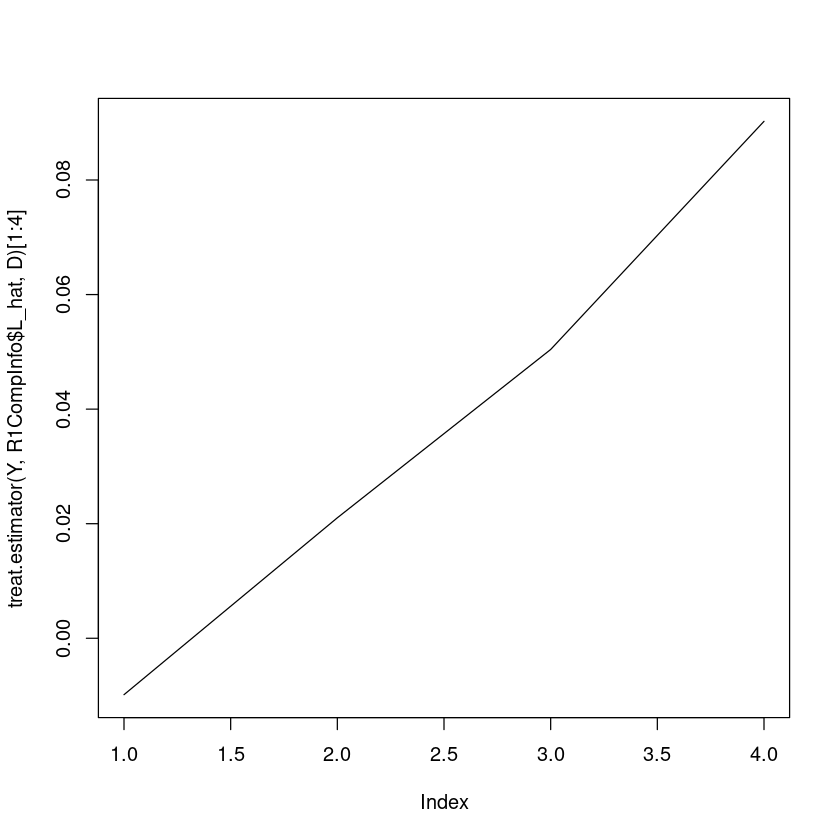

In [125]:
plot(treat.estimator(Y, R1CompInfo$L_hat, D)[1:4], type='l')

In [126]:
allTreatDifferences <- melt(Y-R1CompInfo$L_hat)
names(allTreatDifferences) <- c('stateid', 'year', 'vio_change')

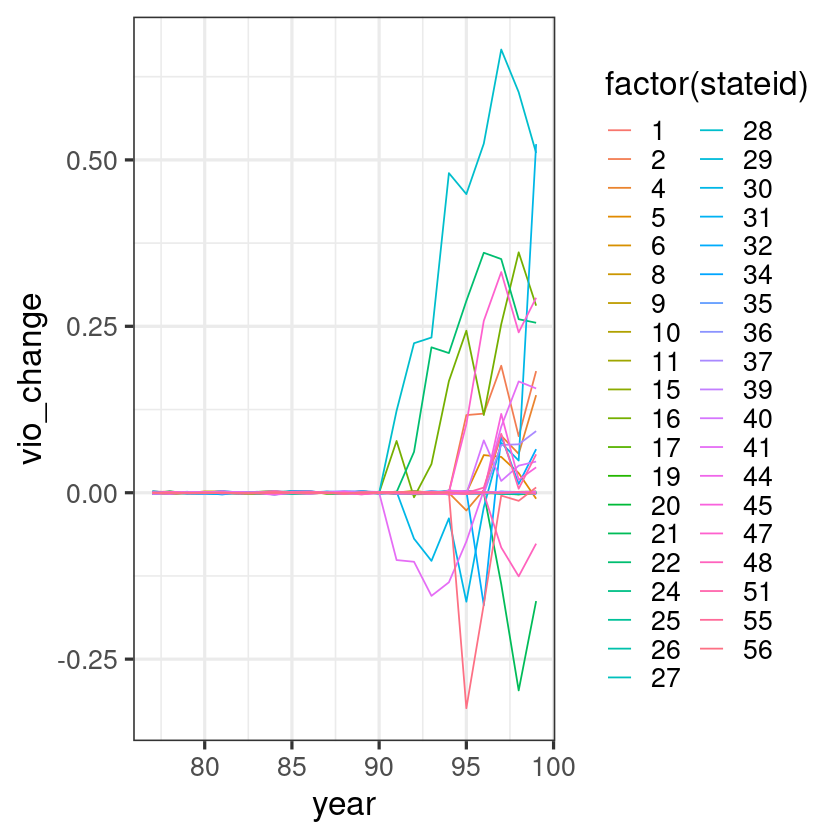

In [127]:
ggplot(allTreatDifferences, aes(x=year, y=vio_change, col=factor(stateid))) + 
geom_line() + theme_bw(base_size=20)

In [128]:
colSums(D)

77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  5  5  5  9 14 17 17 17

# Method Accuracy Assessment


In [129]:
valYearStart = 90

relevantViolenceData <- Y[, as.numeric(dimnames(Y)[[2]]) %in% 77:94]

trainingData <- Y[, as.numeric(dimnames(Y)[[2]]) %in% 1977:(valYearStart-1)]

validationData <- Y[, as.numeric(dimnames(Y)[[2]]) %in% valYearStart:94]

meltedValidationData <- melt(validationData)

names(meltedValidationData) <- c("state", "year", "truth")

savedPredictions <- array(0, dim=c(dim(validationData), 4), dimnames=c(dimnames(validationData), 
                list(c("MC-NNM", "weightedSoftImpute", "FACTOR", "ourMethod"))))

theProbsEstNow <- probMat[, as.numeric(dimnames(probMat)[[2]]) %in% 77:94]

for (state in dimnames(relevantViolenceData)[[1]]){
    ### Remember, this is not comparable to the SDID results because you had
    ### to drop 1970-1974
        
        WThisStateAndYear <- array(0, dim=dim(relevantViolenceData),
                                  dimnames=dimnames(relevantViolenceData))
        
        WThisStateAndYear[state, dimnames(WThisStateAndYear)[[2]] %in% valYearStart:94] <- 1
    
        neededParser <- dimnames(WThisStateAndYear)[[2]] %in% valYearStart:94
        
        probsThisTime <- WThisStateAndYear*(1-theProbsEstNow)+theProbsEstNow
        
        weightsThisTime <- propensity.score.to.weight(probsThisTime, WThisStateAndYear)
        
        mc_nnm_info <- matrix_completion_causal(Y=relevantViolenceData, W=WThisStateAndYear, num_iter=1000, K=4, 
                                        lambda_grid=c(10^seq(-4,2,1), seq(2,5,1)),
                                        tolerance=1e-04)
        
        weightedSoftImputeInfo <- weightedSoftImpute_validate_lambda(Y=relevantViolenceData, W=WThisStateAndYear, 
                                                                     weight_matrix=weightsThisTime, num_iter=1000, K=5, 
                                                             lambda_grid=seq(0, 2000, 10), tolerance=1e-03)
        
        L_completionFactorModel <- completion_factor_model(Y=relevantViolenceData, W=WThisStateAndYear, propScoreMat = probsThisTime,
                                                   numFactors=rankMatrix(mc_nnm_info$L_hat)[1])
        
        completedSmokingInfo <- completion_with_rank_estimation_validate_mu(
                                  Y=relevantViolenceData, W=WThisStateAndYear , weight_matrix=weightsThisTime,
                                  initial_rank=40,
                                  tolerance=1e-04, 
                                  validation_max_iter=5000,
                                  min_iter=100,
                                  max_iter=10000,
                                  mu_grid=0,
                                  K=5)
        
        dimnames(mc_nnm_info$L_hat) <- dimnames(completedSmokingInfo$L_hat)
        dimnames(weightedSoftImputeInfo$L_hat) <- dimnames(completedSmokingInfo$L_hat)
        dimnames(L_completionFactorModel) <- dimnames(completedSmokingInfo$L_hat)
        
        savedPredictions[state, ,] <- rbind(mc_nnm_info$L_hat[state, neededParser], weightedSoftImputeInfo$L_hat[state, neededParser], 
                                                          L_completionFactorModel[state, neededParser], completedSmokingInfo$L_hat[state, neededParser])
        
    
    
    
}

In [130]:
predictionDataFrame <- melt(savedPredictions)
names(predictionDataFrame) <- c("state", "year", "Method","prediction")
predictionDataFrame <- predictionDataFrame %>% inner_join(meltedValidationData)

Joining, by = c("state", "year")



In [131]:
NStepAheadMSETable <- predictionDataFrame %>% group_by( Method) %>% 
 summarize(rmse = sqrt(mean((prediction-truth)^2)),  SE = round(sd((prediction-truth)^2)/sqrt(n()), 2))
names(NStepAheadMSETable) <- c("Method", "RMSE", 'SE')
NStepAheadMSETable$Method <- factor(NStepAheadMSETable$Method, 
    levels=as.character(NStepAheadMSETable$Method)[c(2,4,1,3)])
NStepAheadMSETable <- NStepAheadMSETable[order(NStepAheadMSETable$Method), ]
NStepAheadMSETableLatexed <- knitr::kable(NStepAheadMSETable, "latex")

In [132]:
NStepAheadMSETable

Method,RMSE,SE
<fct>,<dbl>,<dbl>
MC-NNM,1.399924,0.11
weightedSoftImpute,1.194997,0.11
FACTOR,1.427815,0.11
ourMethod,1.234860,0.12


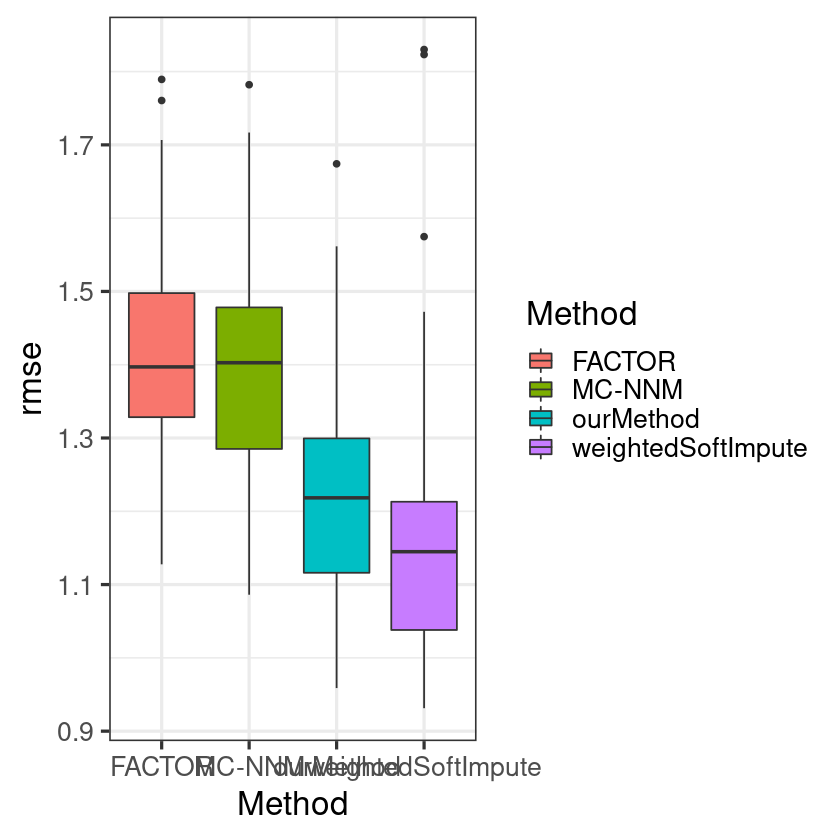

In [134]:
rmseByStateData <- predictionDataFrame %>% group_by(state, Method) %>% summarize(rmse = sqrt(mean((prediction-truth)^2)),
                                                                                 SE = round(sd((prediction-truth)^2)/sqrt(n()), 2))

ggplot(rmseByStateData, aes(x=Method, y=rmse, fill=Method)) + geom_boxplot() + theme_bw(base_size=20)

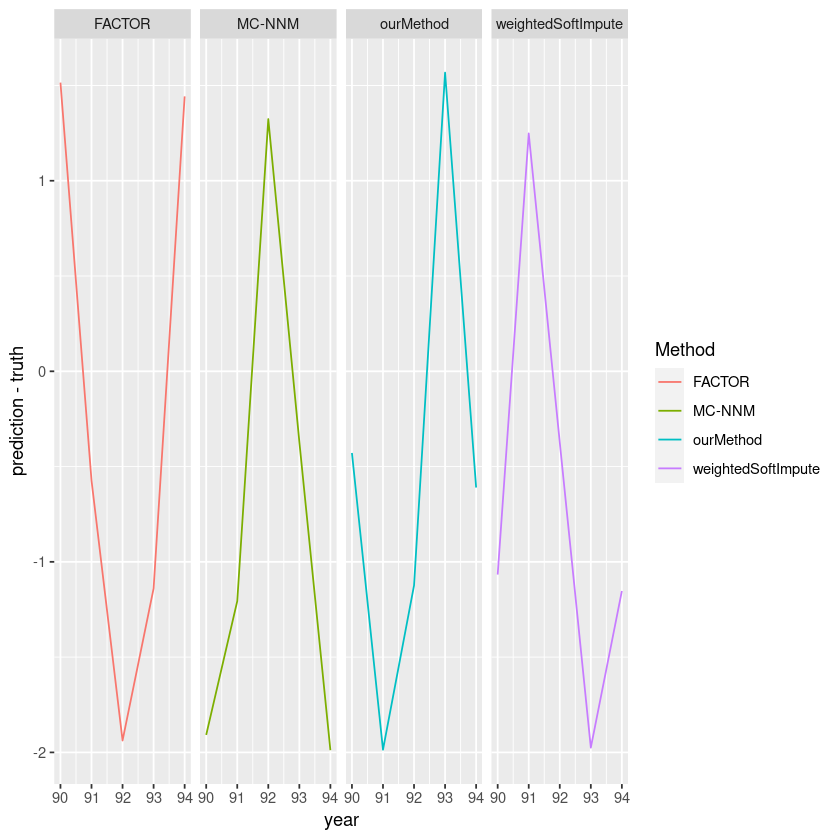

In [135]:
ggplot(predictionDataFrame %>% filter(state==5), aes(x=year, y=prediction-truth, col=Method)) + geom_line() + 
facet_grid(~Method)

In [113]:
boot_ests_weightedSoftImpute <- bootstrapCI(Y=Y, W=D, 
    weightMatrix=weightMat, bootstrap_samps=300, 
    method=weightedSoftImpute_validate_lambda,num_iter=1000 ,
    K=5,
  lambda_grid=seq(0, 2000, 100),
  tolerance=1e-03)

In [114]:
bootEstData <- cbind.data.frame(95:99, colMeans(boot_ests_weightedSoftImpute))
colnames(bootEstData) <- c("Year", "Value")

In [115]:
Cis_weightedSoftImpute <- apply(boot_ests_weightedSoftImpute, MARGIN=2, FUN=bs_percentile_method ,.95)


names(Cis_weightedSoftImpute) <- 95:99


ciExample <- cbind.data.frame(95:99, t(Cis_weightedSoftImpute))
names(ciExample) <- c("Year", "Lower", "Upper")

effectEstimateWithoutCI <- ggplot(data=bootEstData, aes(x=factor(Year), y=Value, group=1)) +
  geom_line(lwd=2)+
  theme_bw(base_size=20)+ xlab("Year") + ylab("Difference in Cigarette Sales (per Capita)") + 
  ggtitle("Estimated Effect of Proposition 99")
                    
effectEstimateWithCI <- ggplot(ciExample, aes(x=factor(Year), y = Upper, group=1)) +
  geom_line(aes(y = Lower), linetype='dashed') + 
  geom_line(aes(y = Upper), linetype='dashed') + 
  geom_line(data=bootEstData, aes(x=factor(Year), y=Value), color='black', lwd=2)+
  geom_ribbon(aes(ymin = Lower, ymax = Upper), fill = "blue", alpha = .5) + 
  theme_bw(base_size=20)+ xlab("Year") + ylab("Difference in log violence rate") + 
  ggtitle("Estimated Effect of Proposition 99,\nwith a 95% Bootstrapped Confidence Interval")

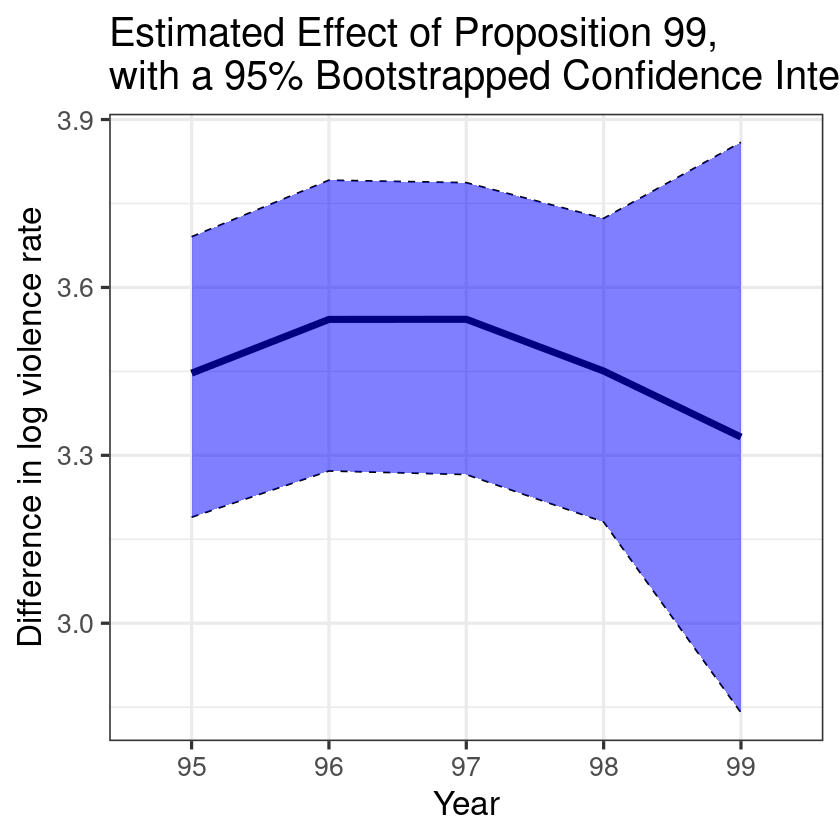

In [116]:
effectEstimateWithCI